Load dependencies:

In [ ]:
# !pip install opensmile
!pip install tensorflow_io
import os
import numpy as np
import librosa
# import opensmile
import math
import scipy
import tensorflow as tf
import tensorflow_io as tfio

directory = "/content/drive/MyDrive/PatientVoiceAI/data"
model_dir = "/content/drive/MyDrive/PatientVoiceAI/saved_models"
img_dir = "/content/drive/MyDrive/PatientVoiceAI/img"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 18.6 MB/s eta 0:00:00


Load and preprocess raw audio files in the dataset:

In [ ]:
def preprocess(x, chunksize):
    x_len = len(x)
    if x_len < chunksize:   # padding
        # processed = np.pad(x, (0,chunksize-x_len))  # right-pad with zero
        processed = np.resize(x, (chunksize,))        # repeat padding
    elif x_len > chunksize: # splitting
        tailing = x_len % chunksize
        if tailing != 0:                # handle uneven splits: create overlap for the last chunk
            x = np.concatenate((x[:-tailing], x[-chunksize:]))
        num_chunks = int(round(len(x)/chunksize))
        processed = np.array_split(x,num_chunks)
    else:                   # no change
        processed = np.array(x)
    return processed

def preprocess_with_overlap(x, chunksize, step_size):   # only used for external audios (typically of length longer than chunksize)
    processed = []
    start_index = 0
    while (start_index+chunksize) <= len(x):
        end_index = start_index+chunksize
        x_slice = x[start_index:end_index]
        processed.append(x_slice)
        start_index += step_size
    if start_index < len(x):
        x_last_slice = x[-chunksize:]   # customise overlap for the last chunk
        processed.append(x_last_slice)
    processed = np.asarray(processed)
    return processed

def get_dataset(label, label_index, chunksize):
    x_set = []
    folder = os.path.join(directory, label)
    for filename in os.listdir(folder):
        f = os.path.join(folder, filename)
        if os.path.isfile(f):
            audio, sample_rate = librosa.load(f)
            x_set.append(preprocess(audio,chunksize))
    x_set = np.vstack(x_set)
    y_set = np.repeat([label_index[label]],len(x_set))
    return x_set,y_set


classes = ["coughing", "sneezing", "speech", "silence"]

label_index = {
    "coughing":0,
    "sneezing":1,
    "speech":2,
    "silence":3
}

sample_rate = 22050   # default sample rate in librosa
chunk_duration = 1.5  # in seconds
chunksize = int(chunk_duration*sample_rate)
step_size = int(0.5*sample_rate)



In [ ]:
## initialise the dataset
x_set = []
y_set = []
for label in classes:
    x_subset, y_subset = get_dataset(label,label_index,chunksize)
    x_set.extend(x_subset)
    y_set.extend(y_subset)

x_set = np.asarray(x_set).astype('float32')
y_set = np.asarray(y_set)

print(np.shape(x_set))
print(x_set[0])
print(np.shape(y_set))
print(y_set[0])



(13143, 22050)
[ 0.03695566  0.04142303  0.01117673 ... -0.00079513 -0.00081604
 -0.0008231 ]
(13143,)
0


Store the dataset into a .csv file:

In [ ]:
# preprocessed_dataset = np.hstack((x_set, np.expand_dims(y_set,axis=1)))
# np.savetxt('preprocessed_dataset.csv', preprocessed_dataset, fmt="%d", delimiter=",")

Shuffle and split the dataset:

In [ ]:
#Parameters for shuffling
seed = 42
np.random.seed(seed)
N = len(y_set)

shuffled_indices = np.random.permutation(N)

# Apply the shuffled indices to both data and labels
x_set = x_set[shuffled_indices]
y_set = y_set[shuffled_indices]


split_size_val = int(0.8*N)
split_size_test = int(0.9*N)

x_train, x_val, x_test = x_set[:split_size_val], x_set[split_size_val:split_size_test], x_set[split_size_test:]
y_train, y_val, y_test = y_set[:split_size_val], y_set[split_size_val:split_size_test], y_set[split_size_test:]

print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(10514, 22050)
(1314, 22050)
(1315, 22050)


Define a function to calculate normalised Mel-spectrogram:

In [ ]:
def get_normalised_mel_spectrogram(x, sr=sample_rate, n_mel_bins=20):
    """
          Code adapted from https://github.com/douglas125/SpeechCmdRecognition/blob/master/audioUtils.py#L93
    """
    spec_stride = 128
    spec_len = 1024

    spectrogram = tfio.audio.spectrogram(
        x, nfft=spec_len, window=spec_len, stride=spec_stride
    )

    num_spectrogram_bins = spec_len // 2 + 1  # spectrogram.shape[-1]
    lower_edge_hertz, upper_edge_hertz = 40.0, 8000.0
    num_mel_bins = n_mel_bins
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins, num_spectrogram_bins, sr, lower_edge_hertz,
      upper_edge_hertz)
    mel_spectrograms = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
    avg = tf.math.reduce_mean(log_mel_spectrograms)
    std = tf.math.reduce_std(log_mel_spectrograms)

    return (log_mel_spectrograms - avg) / std


# testing
# print(get_normalised_mel_spectrogram(x_set[1]))

Define a function to calculate MFCCs:
1. Support deltas
   
   reasoning behind using deltas: https://www.cs.cmu.edu/afs/cs/user/robust/www/Papers/KumarKimSternICA11.pdf
2. Only take first 13?
   
   https://www.quora.com/In-speech-processing-why-do-we-consider-only-first-13-MFCCs

In [ ]:
def get_mfccs(x, sr=sample_rate, n=20, deltas=False):

    log_mel_spectrograms = get_normalised_mel_spectrogram(x, sr=sr, n_mel_bins=n)

    ## Compute MFCCs from log_mel_spectrograms and take the first 13
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :13]
    # convert MFCCs into the shape of NHWC format (4D: batch_size, height, width, channels)
    mfccs = tf.expand_dims(mfccs,axis=-1)
    if not deltas:
        return mfccs

    ## calculate delta MFCCs
    # define the kernel in the shape of (4D: filter_height, filter_width, in_channels, out_channels)
    kernel_delta_array = np.array([
        [ 0, 1, 0 ],
        [ 0, 0, 0 ],
        [ 0, -1, 0 ]])
    kernel_delta = tf.constant(kernel_delta_array*0.5, dtype=tf.float32)
    kernel_delta = tf.expand_dims(kernel_delta,axis=2)
    kernel_delta = tf.expand_dims(kernel_delta,axis=3)

    # convolve the kernel with MFCCs
    delta_MFCCs = tf.nn.conv2d(
          mfccs,
          kernel_delta,
          strides = [1,1,1,1],
          padding="SAME")

    ## calculate double delta MFCCs
    # define the kernel in the shape of (4D: filter_height, filter_width, in_channels, out_channels)
    kernel_double_delta_array = np.array([
        [ 0, 0, 2, 0, 0 ],
        [ 0, 0, 1, 0, 0 ],
        [ 0, 0, 0, 0, 0 ],
        [ 0, 0, -1, 0, 0 ],
        [ 0, 0, -2, 0, 0 ]])
    kernel_double_delta = tf.constant(kernel_double_delta_array*0.1, dtype=tf.float32)
    kernel_double_delta = tf.expand_dims(kernel_double_delta,axis=2)
    kernel_double_delta = tf.expand_dims(kernel_double_delta,axis=3)

    # convolve the kernel with MFCCs
    double_delta_MFCCs = tf.nn.convolution(
          mfccs,
          kernel_double_delta,
          strides = [1,1,1,1],
          padding="SAME")

    ## combine the MFCCs with deltas and double deltas
    combined_MFCCs = (tf.concat((mfccs,delta_MFCCs,double_delta_MFCCs),axis=2))

    return combined_MFCCs

# testing
# print(get_mfccs([x_set[1]],deltas=True))

tf.Tensor(
[[[[-1.1391327e+00]
   [ 4.5120702e+00]
   [ 8.9796460e-01]
   ...
   [-8.4176324e-02]
   [-5.4025456e-02]
   [ 1.9546568e-02]]

  [[-8.6550301e-01]
   [ 4.4316506e+00]
   [ 8.2762676e-01]
   ...
   [-7.2255053e-02]
   [-1.3231782e-02]
   [ 6.5542944e-02]]

  [[-5.8968824e-01]
   [ 4.1779132e+00]
   [ 6.7887598e-01]
   ...
   [-8.9412704e-03]
   [ 6.5258205e-02]
   [ 9.1923885e-02]]

  ...

  [[-8.1044227e-01]
   [ 2.5797966e+00]
   [ 2.7624258e-01]
   ...
   [ 7.7299535e-02]
   [ 1.1543093e-02]
   [-6.2442971e-03]]

  [[-6.1357007e+00]
   [ 2.3233545e+00]
   [ 4.0918165e-01]
   ...
   [ 6.3506462e-02]
   [ 4.5327272e-02]
   [-5.1596239e-03]]

  [[-2.3010492e+01]
   [ 4.9411267e-02]
   [-6.2049234e-01]
   ...
   [ 3.1159768e-02]
   [ 5.7488121e-02]
   [-3.6790131e-03]]]], shape=(1, 173, 39, 1), dtype=float32)


Build a model:

In [ ]:
"""
      Code adapted from https://github.com/douglas125/SpeechCmdRecognition/blob/master/SpeechModels.py
"""

from tensorflow import keras
from keras import layers as L
from keras import backend as K
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras import optimizers
from keras.models import Model, load_model


def get_melspec_model(iLen=None):
    inp = L.Input((iLen,), name='input')
    mel_spec = get_normalised_mel_spectrogram(inp)
    melspecModel = Model(inputs=inp, outputs=mel_spec, name='normalised_spectrogram_model')
    return melspecModel

def get_mfccs_model(iLen=None):
    inp = L.Input((iLen,), name='input')
    mfccs = get_mfccs(inp, deltas=True)
    mfccsModel = Model(inputs=inp, outputs=mfccs, name='normalised_mfccs_model')
    return mfccsModel

def AttRNNSpeechModel(nCategories, samplingrate=sample_rate,
                      inputLength=chunksize, rnn_func=L.LSTM):
    # simple LSTM
    sr = samplingrate
    iLen = inputLength

    inputs = L.Input((inputLength,), name='input')

    m =  get_melspec_model(iLen=inputLength)
    # m =  get_mfccs_model(iLen=inputLength)
    m.trainable = False

    x = m(inputs)
    x = tf.expand_dims(x, axis=-1, name='mel_stft')   # only required for mel-spectrograms

    x = L.Conv2D(10, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(1, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)


    x = L.Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim')(x)

    x = L.Bidirectional(rnn_func(64, return_sequences=True)
                        )(x)
    x = L.Bidirectional(rnn_func(64, return_sequences=True)
                        )(x)

    # for classification
    x = L.GlobalAveragePooling1D()(x)
    x = L.Dense(64, activation='relu')(x)      #(attVector)
    x = L.Dense(32)(x)

    output = L.Dense(nCategories, activation='softmax', name='output')(x)

    model = Model(inputs=[inputs], outputs=[output])

    return model

Create a model:

In [ ]:
nCategs = len(classes)
model = AttRNNSpeechModel(nCategs, samplingrate = sample_rate, inputLength = None)#, rnn_func=L.LSTM)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None)]            0         
                                                                 
 normalised_spectrogram_mod  (None, None, 20)          0         
 el (Functional)                                                 
                                                                 
 tf.expand_dims (TFOpLambda  (None, None, 20, 1)       0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, None, 20, 10)      60        
                                                                 
 batch_normalization (Batch  (None, None, 20, 10)      40        
 Normalization)                                                  
                                                             

Train the model:

In [ ]:
import math
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop,
            math.floor((1+epoch)/epochs_drop))

    if (lrate < 4e-5):
        lrate = 4e-5

    print('Changing learning rate to {}'.format(lrate))
    return lrate

model_name = 'model-spec-RNN-90s.h5'
model_path = os.path.join(model_dir, model_name)
lrate = LearningRateScheduler(step_decay)
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint(model_path, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val,y_val), use_multiprocessing=False,
                    callbacks=[earlystopper, checkpointer, lrate])



Changing learning rate to 0.001
Epoch 1/50
232/232 [==============================] - ETA: 0s - loss: 0.3912 - sparse_categorical_accuracy: 0.8608
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.85946, saving model to /content/drive/MyDrive/PatientVoiceAI/saved_models/model-spec-RNN-90s.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


232/232 [==============================] - 247s 1s/step - loss: 0.3912 - sparse_categorical_accuracy: 0.8608 - val_loss: 0.3760 - val_sparse_categorical_accuracy: 0.8595 - lr: 0.0010
Changing learning rate to 0.001
Epoch 2/50
232/232 [==============================] - ETA: 0s - loss: 0.2033 - sparse_categorical_accuracy: 0.9331
Epoch 2: val_sparse_categorical_accuracy improved from 0.85946 to 0.92865, saving model to /content/drive/MyDrive/PatientVoiceAI/saved_models/model-spec-RNN-90s.h5
232/232 [==============================] - 217s 938ms/step - loss: 0.2033 - sparse_categorical_accuracy: 0.9331 - val_loss: 0.2289 - val_sparse_categorical_accuracy: 0.9286 - lr: 0.0010
Changing learning rate to 0.001
Epoch 3/50
232/232 [==============================] - ETA: 0s - loss: 0.1439 - sparse_categorical_accuracy: 0.9538
Epoch 3: val_sparse_categorical_accuracy improved from 0.92865 to 0.95892, saving model to /content/drive/MyDrive/PatientVoiceAI/saved_models/model-spec-RNN-90s.h5
232/232 [

KeyboardInterrupt: 

K-fold split for cross validation:

In [ ]:
def k_fold_split(n_splits, n_instances):
    """ Split n_instances into n mutually exclusive splits at random.

    Args:
        n_splits (int): Number of splits
        n_instances (int): Number of instances to split
        random_generator (np.random.Generator): A random generator

    Returns:
        list: a list (length n_splits). Each element in the list should contain a
            numpy array giving the indices of the instances in that split.
    """
    # initialise random seed
    seed = 42
    np.random.seed(seed)

    # generate a random permutation of indices from 0 to n_instances
    shuffled_indices = np.random.permutation(n_instances)

    # split shuffled indices into almost equal sized splits
    split_indices = np.array_split(shuffled_indices, n_splits)

    return split_indices

def train_test_k_fold(n_folds, n_instances):
    """ Generate train and test indices at each fold.

    Args:
        n_folds (int): Number of folds
        n_instances (int): Total number of instances
        random_generator (np.random.Generator): A random generator

    Returns:
        list: a list of length n_folds. Each element in the list is a list (or tuple)
            with two elements: a numpy array containing the train indices, and another
            numpy array containing the test indices.
    """

    # split the dataset into k splits
    split_indices = k_fold_split(n_folds, n_instances)

    folds = []
    for k in range(n_folds):
        # pick k as test
        test_indices = split_indices[k]

        # combine remaining splits as train
        train_indices = np.hstack(split_indices[:k] + split_indices[k+1:])

        folds.append([train_indices, test_indices])

    return folds

Cross validation:

In [ ]:
def cross_validation(x,y,n_folds=10):
    error_test_list = []
    error_train_list = []
    acc_test_list = []
    acc_train_list = []
    for i, (train_indices, test_indices) in enumerate(train_test_k_fold(n_folds, len(x))):

        print("Fold ",i)

        # get the dataset from the correct splits
        x_train = x[train_indices, :]
        y_train = y[train_indices]
        x_test = x[test_indices, :]
        y_test = y[test_indices]

        nCategs = len(classes)
        model = AttRNNSpeechModel(nCategs, samplingrate = sample_rate, inputLength = None)#, rnn_func=L.LSTM)
        model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
        model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=0)
        error_test, acc_test = model.evaluate(x_test, y_test, verbose=0)
        print("\nModel error (test): {}\n".format(error_test))
        print("\nModel accuracy (test): {}\n".format(acc_test))
        error_train, acc_train = model.evaluate(x_train, y_train, verbose=0)
        print("\nModel error (train): {}\n".format(error_train))
        print("\nModel accuracy (train): {}\n".format(acc_train))

        error_test_list.append(error_test)
        error_train_list.append(error_train)
        acc_test_list.append(acc_test)
        acc_train_list.append(acc_train)
    return (error_test_list, error_train_list, acc_test_list, acc_train_list)

In [ ]:
error_test_list, error_train_list, acc_test_list, acc_train_list = cross_validation(x_set,y_set)

Fold  0

Model error (test): 0.12293131649494171


Model accuracy (test): 0.9657794833183289


Model error (train): 0.026847349479794502


Model accuracy (train): 0.9901927709579468

Fold  1

Model error (test): 0.14222536981105804


Model accuracy (test): 0.9634981155395508


Model error (train): 0.08874315768480301


Model accuracy (train): 0.9741291999816895

Fold  2

Model error (test): 0.1675052046775818


Model accuracy (test): 0.9558935165405273


Model error (train): 0.0408640131354332


Model accuracy (train): 0.9863036870956421

Fold  3

Model error (test): 0.1287805736064911


Model accuracy (test): 0.969558596611023


Model error (train): 0.021491162478923798


Model accuracy (train): 0.9924761056900024

Fold  4

Model error (test): 0.15034858882427216


Model accuracy (test): 0.9619482755661011


Model error (train): 0.026928933337330818


Model accuracy (train): 0.9902781248092651

Fold  5

Model error (test): 0.10078427940607071


Model accuracy (test): 0.973363757133483

Plot the training history:

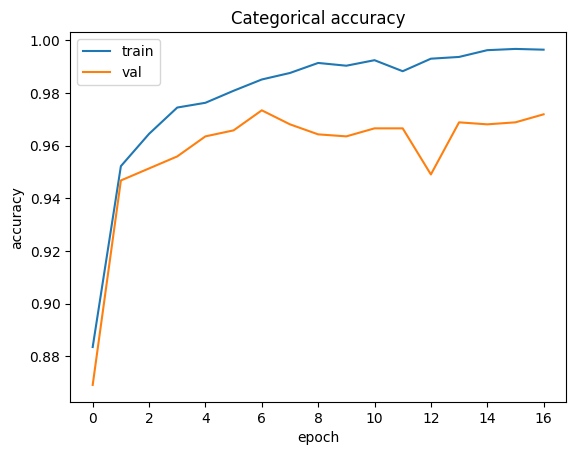

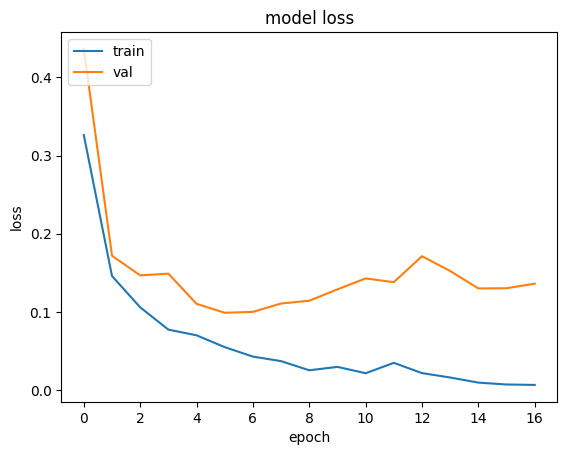

In [ ]:
import matplotlib.pyplot as plt

# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Load the previously saved weights:

In [ ]:
## load the previously saved weights
model_name = 'model-spec-RNN-90s.h5'
model_path = os.path.join(model_dir, model_name)
model.load_weights(model_path)

Evaluate on the test set:

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12844231724739075
Test accuracy: 0.970342218875885


Perform predictions on the test set and calculate the confusion matrix:

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test, verbose=1)
y_pred = np.argmax(y_pred,1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

42/42 [==============================] - 2s 15ms/step
[[549   3   8   1]
 [  5  82   6   1]
 [ 10   5 635   0]
 [  0   0   0  10]]


Function to predict for an external audio:

In [ ]:
classes = np.asarray(classes)
def predict_framewise(x, chunksize=chunksize, model=model):
    # preprocess the input audio
    x = np.asarray(preprocess_with_overlap(x, chunksize, step_size)).astype('float32')
    # feed it into the model to produce predictions
    y_pred = model.predict(x)
    y_pred_probs = np.max(y_pred, axis=1)   # the probability of the highest scoring class
    y_pred_categorical = np.argmax(y_pred, axis=1)
    y_pred_labels = classes[y_pred_categorical]   # the label of the highest scoring class
    y_pred_speech = y_pred[:,list(classes).index("speech")]   # probability that the segment is speech
    return y_pred_labels, y_pred_probs, y_pred_speech

def predict_shorter_framewise(x, frame_duration, chunksize=chunksize, model=model):
    # preprocess the input audio
    # 1. split into frames
    x = np.asarray(preprocess(x, int(frame_duration*sample_rate))).astype('float32')
    # 2. extract features for each frame
    new_x = []
    for x_slice in x:
        new_x_slice = np.squeeze(preprocess(x_slice, chunksize))
        new_x.append(new_x_slice)
    x = np.asarray(new_x)
    # print(np.shape(x))        # for debugging

    # feed it into the model to produce predictions
    y_pred = model.predict(x)
    y_pred_probs = np.max(y_pred, axis=1)   # the probability of the highest scoring class
    y_pred_categorical = np.argmax(y_pred, axis=1)
    y_pred_labels = classes[y_pred_categorical]   # the label of the highest scoring class
    y_pred_speech = y_pred[:,list(classes).index("speech")]   # probability that the segment is speech
    return y_pred_labels, y_pred_probs, y_pred_speech

A plotter to plot the prediction result for the audio:

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.interpolate import make_interp_spline

class TimescalePlotter:
    def __init__(self, time_values:list, label_values:list, prob_values:list, speech_values:list, filename:str, gold_label:str, color_map={'coughing': 'red', 'sneezing': 'blue', 'speech': 'green', 'silence': 'grey'}):
        data = {
            'Time': time_values,
            'Label': label_values,
            'Probability': prob_values,
        }
        if len(time_values) != len(label_values):
            print(len(time_values))
            print(len(label_values))
        self.df = pd.DataFrame(data)
        self.color_map = color_map
        self.intervals = self._get_intervals()
        self.merged_intervals = self._merge_intervals()     # neglecting probs
        self.filename = filename[:-4]
        self.speech_probs = speech_values

    def _merge_intervals(self):
        merged_intervals = []
        current_label = self.df['Label'].iloc[0]
        start_time = self.df['Time'].iloc[0]

        for i in range(1, len(self.df)):
            if self.df['Label'].iloc[i] != current_label:
                merged_intervals.append((start_time, self.df['Time'].iloc[i], current_label))
                current_label = self.df['Label'].iloc[i]
                start_time = self.df['Time'].iloc[i]

        # Add the last interval
        merged_intervals.append((start_time, self.df['Time'].iloc[-1] + 1, current_label))
        return merged_intervals

    def _get_intervals(self):
        intervals = []
        current_label = self.df['Label'].iloc[0]
        current_prob = self.df['Probability'].iloc[0]
        start_time = self.df['Time'].iloc[0]

        for i in range(1, len(self.df)):
            intervals.append((start_time, self.df['Time'].iloc[i], current_label, current_prob))
            current_label = self.df['Label'].iloc[i]
            current_prob = self.df['Probability'].iloc[i]
            start_time = self.df['Time'].iloc[i]

        # Add the last interval
        intervals.append((start_time, self.df['Time'].iloc[-1] + 1, current_label, current_prob))
        return intervals

    def plot(self, figsize=(20, 2)):
        fig, ax = plt.subplots(figsize=figsize)  # Adjust the height by setting figsize to (width, height)

        ## Add colored intervals regardless of probabilities
        # for start_time, end_time, label in self.merged_intervals:
        #     ax.axvspan(start_time, end_time, color=self.color_map[label], alpha=0.3, label=label)

        # Add colored intervals with transparencies corresponding to probabilities
        for start_time, end_time, label, prob in self.intervals:
            ax.axvspan(start_time, end_time, color=self.color_map[label], alpha=prob, label=label)

        # # Add dummy entries for labels not present in data
        # for label, color in self.color_map.items():
        #     if label not in self.df['Label'].unique():
        #         ax.axvspan(np.NaN, np.NaN, color=color, alpha=0.3, label=label)

        # Formatting the plot
        ax.set_xlim(self.df['Time'].min() - 1, self.df['Time'].max() + 2)  # Adjust x-axis limits
        ax.set_ylim(0, 1.0)  # Adjust y-axis limits to focus on the labels
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('Label')
        ax.set_title("Framewise Classification of "+self.filename+".wav")  # Set the plot title

        # Customizing ticks and grid
        ax.xaxis.set_major_locator(plt.MaxNLocator(10))  # Show up to 10 major ticks on the x-axis
        ax.yaxis.set_visible(False)  # Hide y-axis
        ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)

        # Create custom legend handles with alpha=1.0
        unique_handles = [plt.Line2D([0, 1], [0, 0], color=color, lw=8, alpha=1.0) for label, color in self.color_map.items()]
        unique_labels = [*self.color_map]
        # Add legend with custom handles
        ax.legend(handles=unique_handles, labels=unique_labels, loc='upper right')

        # Display the plot
        plt.savefig(os.path.join(img_dir,self.filename)+".png")


    def plot_speech_probs(self, figsize=(20, 2), k=2):
        time_intervals = self.df['Time']
        probability_data = self.speech_probs

        # Spline interpolation for smooth curve
        x_smooth = np.linspace(time_intervals.min(), time_intervals.max(), 300)
        spl = make_interp_spline(time_intervals, probability_data, k=k)  # k is the degree of the splines
        y_smooth = spl(x_smooth)
        # Clip the smoothed data to ensure it remains within [0, 1]
        y_smooth = np.clip(y_smooth, 0, 1)

        plt.figure(figsize=figsize)
        plt.plot(x_smooth, y_smooth, color='b', label='Smoothed Curve')
        plt.scatter(time_intervals, probability_data, color='r', label='Original Datapoints')  # Optional: show original data points
        plt.title("Speech Probability of "+self.filename+".wav")
        plt.xlabel('Time')
        plt.ylabel('Speech Probability')
        plt.grid(True)
        plt.legend(loc='upper right')
        plt.savefig(os.path.join(img_dir,self.filename)+"_speech_probs.png")

    def plot_allinone(self, figsize=(20, 2), k=2):
        fig, ax = plt.subplots(figsize=figsize)  # Adjust the height by setting figsize to (width, height)

        ## Add colored intervals regardless of probabilities
        # for start_time, end_time, label in self.merged_intervals:
        #     ax.axvspan(start_time, end_time, color=self.color_map[label], alpha=0.3, label=label)

        # Add colored intervals with transparencies corresponding to probabilities
        for start_time, end_time, label, prob in self.intervals:
            ax.axvspan(start_time, end_time, color=self.color_map[label], alpha=prob, label=label)

        # # Add dummy entries for labels not present in data
        # for label, color in self.color_map.items():
        #     if label not in self.df['Label'].unique():
        #         ax.axvspan(np.NaN, np.NaN, color=color, alpha=0.3, label=label)

        # Formatting the plot
        ax.set_xlim(self.df['Time'].min() - 1, self.df['Time'].max() + 2)  # Adjust x-axis limits
        ax.set_ylim(0, 1.05)  # Adjust y-axis limits to focus on the labels
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('Speech Probability')
        ax.set_title("Framewise Classification and Speech Probability of "+self.filename+".wav")  # Set the plot title

        # Prepare data for plotting the speech probability curve line
        time_intervals = self.df['Time']
        probability_data = self.speech_probs

        # Spline interpolation for smooth curve
        x_smooth = np.linspace(time_intervals.min(), time_intervals.max(), 300)
        spl = make_interp_spline(time_intervals, probability_data, k=k)  # k is the degree of the splines
        y_smooth = spl(x_smooth)
        # Clip the smoothed data to ensure it remains within [0, 1]
        y_smooth = np.clip(y_smooth, 0, 1)

        # Plot the speech probability curve line
        ax.plot(x_smooth, y_smooth, color='white', alpha=0.85, label='Speech Probability')
        # ax.scatter(time_intervals, probability_data, color='white', label='Original Data')  # Optional: show original data points
        # ax.grid(True)

        # Customizing ticks and grid
        ax.xaxis.set_major_locator(plt.MaxNLocator(10))  # Show up to 10 major ticks on the x-axis
        # ax.yaxis.set_visible(False)  # Hide y-axis
        ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)

        # Get existing legend handles and labels
        handles, labels = ax.get_legend_handles_labels()
        # Create custom legend handles with alpha=1.0
        unique_handles = [plt.Line2D([0, 1], [0, 0], color=color, lw=8, alpha=1.0) for label, color in self.color_map.items()]
        unique_handles.append(handles[-1])
        unique_labels = [*self.color_map]
        unique_labels.append(labels[-1])
        # Add legend with custom handles
        ax.legend(handles=unique_handles, labels=unique_labels, bbox_to_anchor=(1, 1), facecolor='gold', framealpha=0.5)

        # Display the plot
        # plt.show()
        plt.savefig(os.path.join(img_dir,self.filename)+"_allinone.png")



Calculate health indicators:
1. speech ratio
2. disruption ratio

In [ ]:
## calculate label ratios as health indicators
def calculate_health_indicators(pred_labels):
    classes, counts = np.unique(pred_labels,return_counts=True)
    counts_dict = dict(zip(classes,counts))
    speech_count = counts_dict['speech'] if 'speech' in counts_dict else 0
    speech_ratio = speech_count/np.sum(counts)
    disruption_ratio = (np.sum(counts) - speech_count) / np.sum(counts)
    return speech_ratio,disruption_ratio

Test an example of an external audio:

5/5 [==============================] - 1s 202ms/step


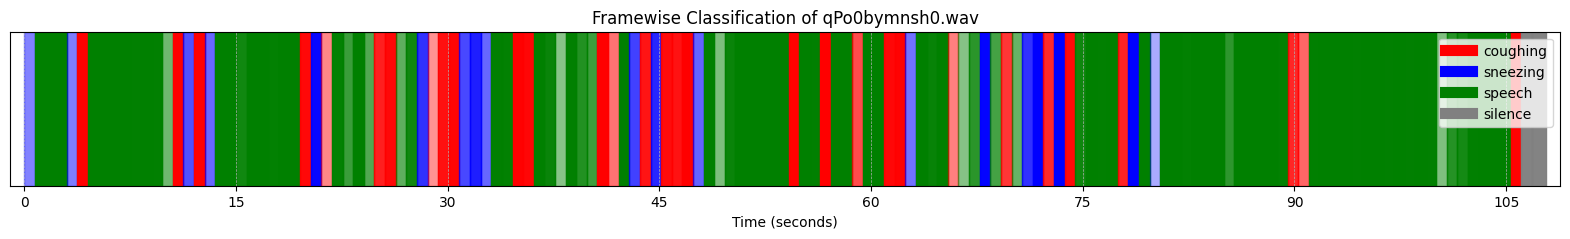

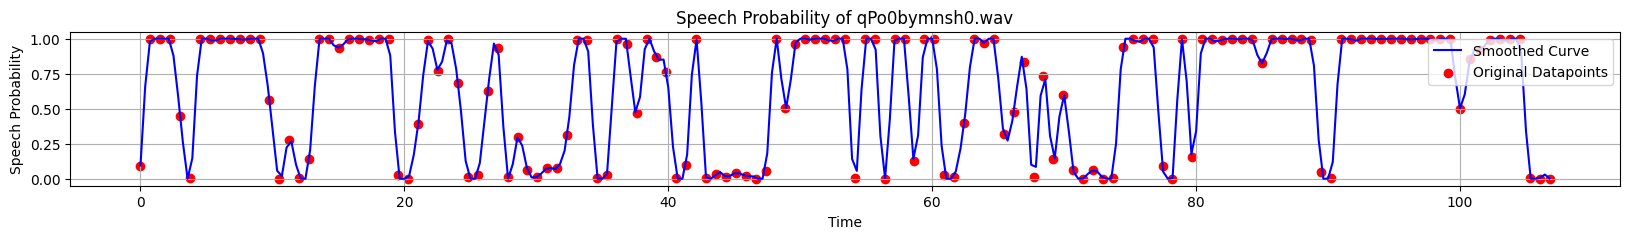

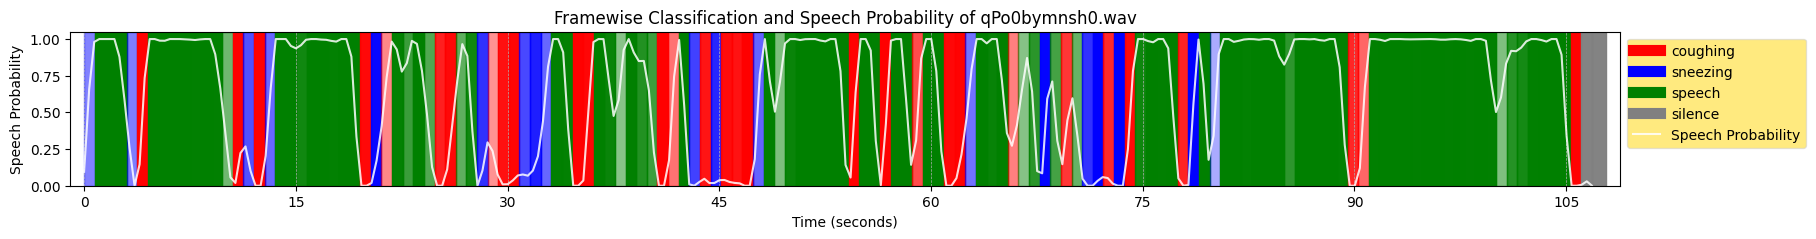

In [ ]:
# testing
eg_label = "mixed"
eg_filename = "qPo0bymnsh0.wav"
eg_f = os.path.join(directory, eg_label, eg_filename)
eg_x, eg_sr = librosa.load(eg_f)
# eg_processed = preprocess_with_overlap(eg_x,chunksize,step_size)
# print(len(eg_x),eg_sr)
# print(np.shape(eg_processed))
# print(eg_processed)
frame_duration = 0.75
eg_y_labels, eg_y_probs, eg_y_speech = predict_shorter_framewise(eg_x,frame_duration)
# print(eg_y_labels)
# print(eg_y_probs)
# print(eg_y_speech)

# # chunk_duration = 1.5   # in second    # defined earlier

eg_audio_duration = float(len(eg_x)/eg_sr) # chunk_duration*len(eg_y_labels)
eg_timestamps = np.linspace(start=0, stop=eg_audio_duration, num=len(eg_y_labels))
plotter = TimescalePlotter(list(eg_timestamps), list(eg_y_labels), list(eg_y_probs), eg_y_speech, eg_filename, eg_label)
plotter.plot()
plotter.plot_speech_probs()
plotter.plot_allinone()


NOTE:

"Speech probability" can be regarded as an indicator of voice stability, as more shaky voices are more likely to be confused with non-speech types, hence having a lower confidence in prediction.

Test on the entire batch of external audios:

qPo0bymnsh0.wav: 
5/5 [==============================] - 2s 316ms/step
9C12ZvOJNfs.wav: 
8/8 [==============================] - 3s 363ms/step
JQULoZruOqA.wav: 
7/7 [==============================] - 2s 223ms/step
Xhuqg1B-QQU.wav: 
6/6 [==============================] - 1s 216ms/step
hZ_k79d_QU0.wav: 
9/9 [==============================] - 3s 308ms/step
M4w75R9E0AQ.wav: 
4/4 [==============================] - 1s 195ms/step
Vy9_f8sBKyA.wav: 
21/21 [==============================] - 6s 302ms/step
j8SA1XuNA_w.wav: 
3/3 [==============================] - 1s 182ms/step
DAuLYT9gnhI.wav: 
3/3 [==============================] - 1s 166ms/step
5nYoRdi5IXU.wav: 
5/5 [==============================] - 2s 314ms/step


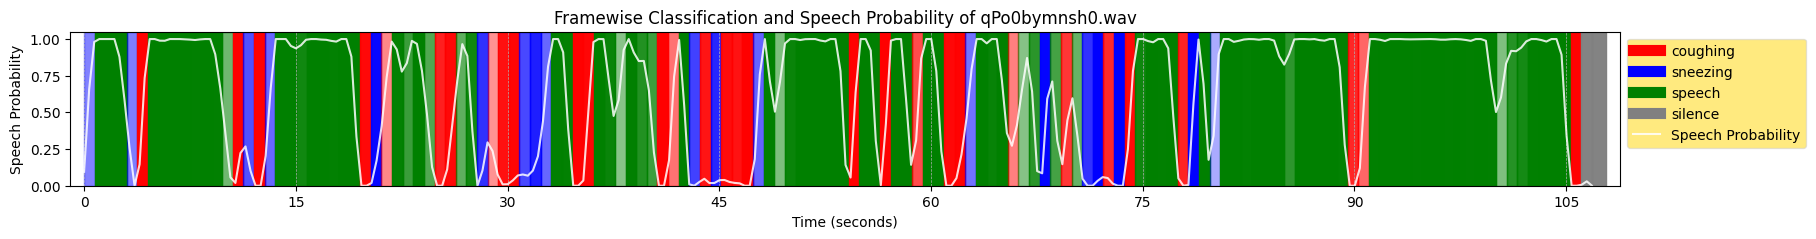

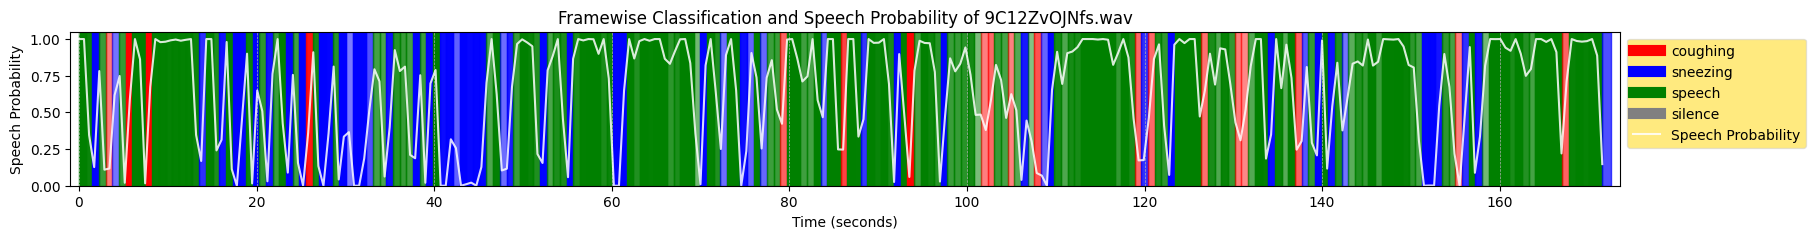

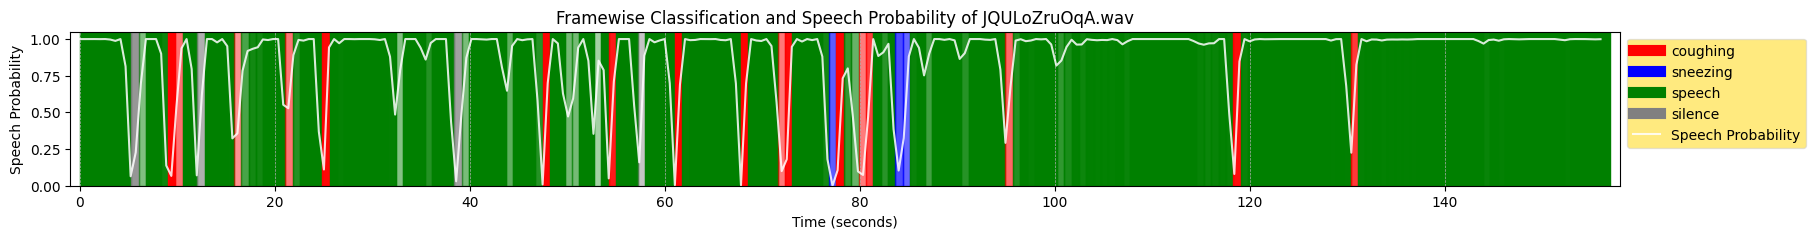

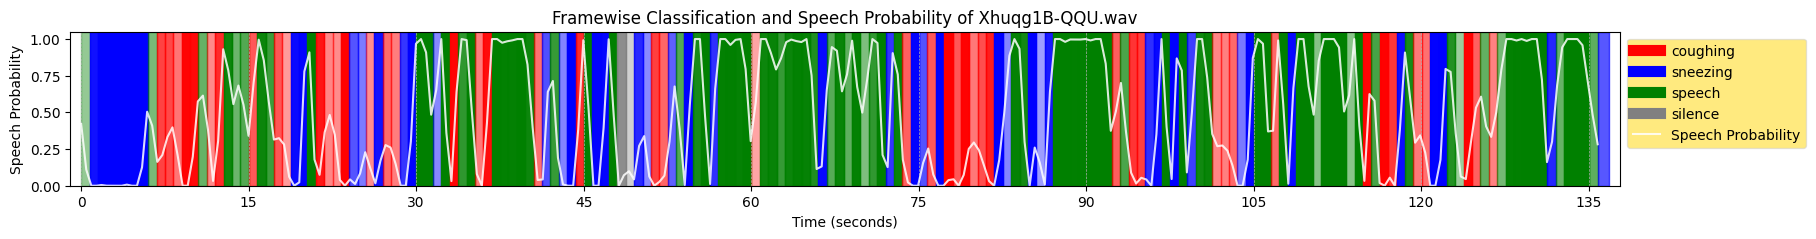

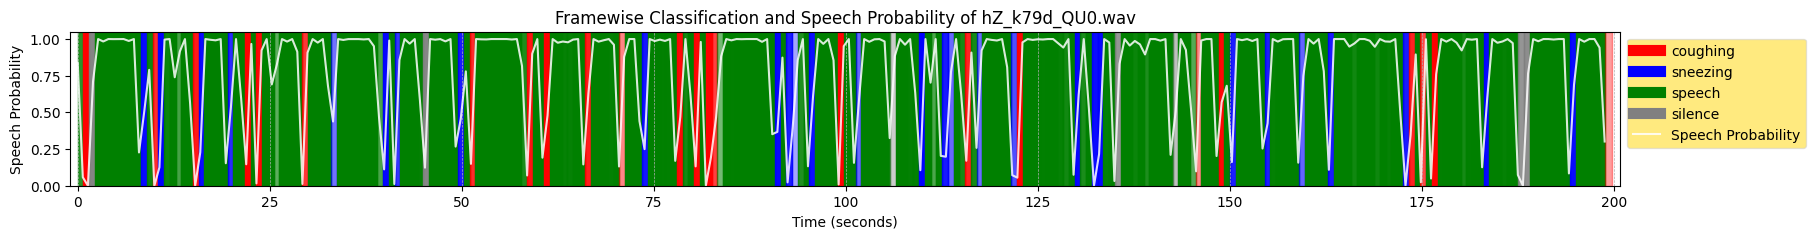

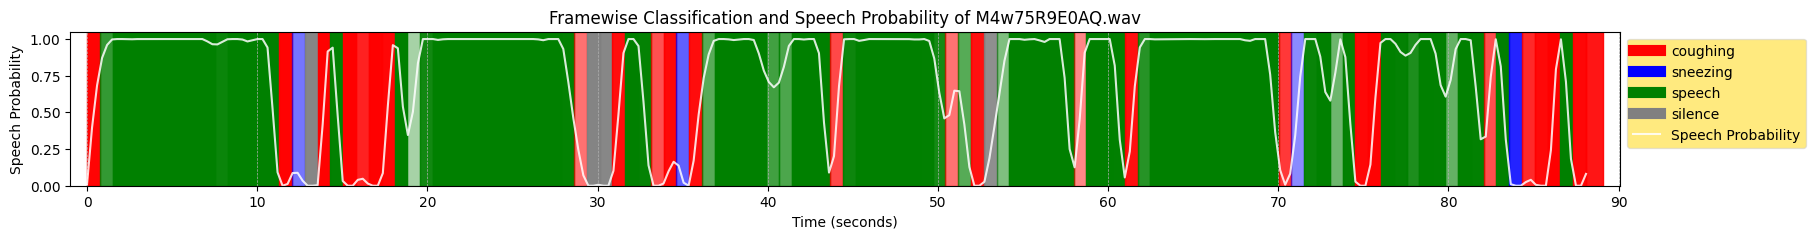

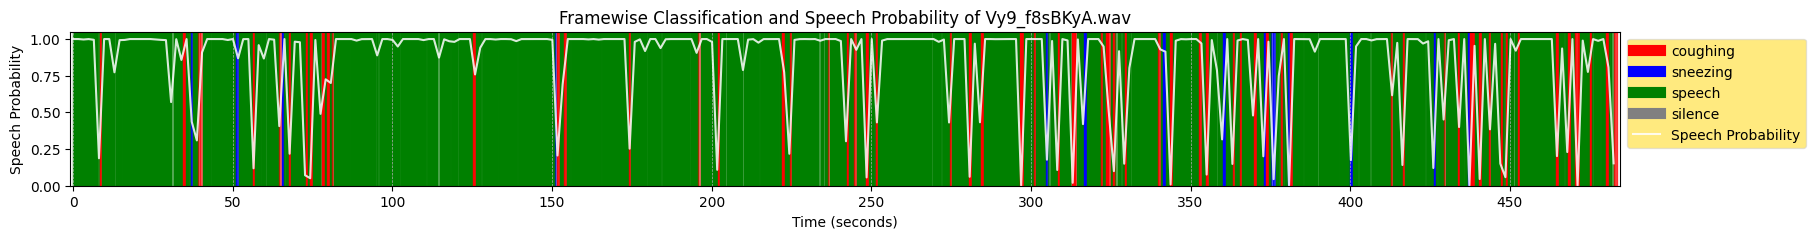

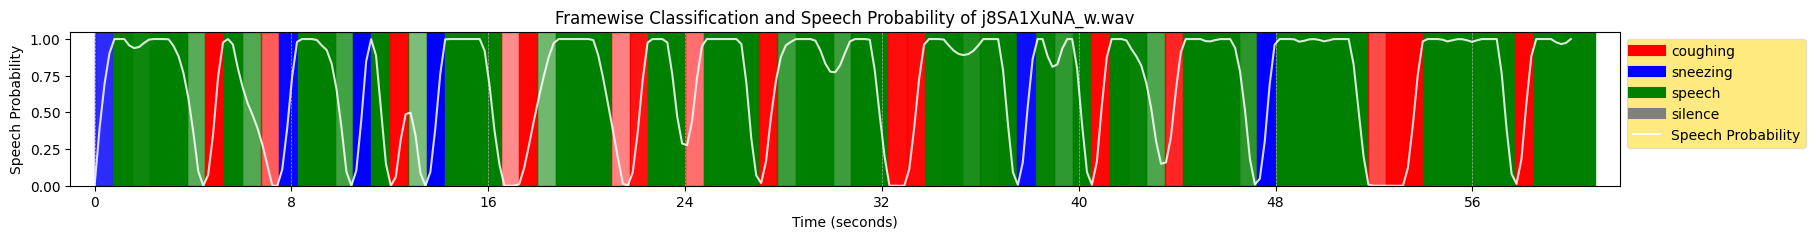

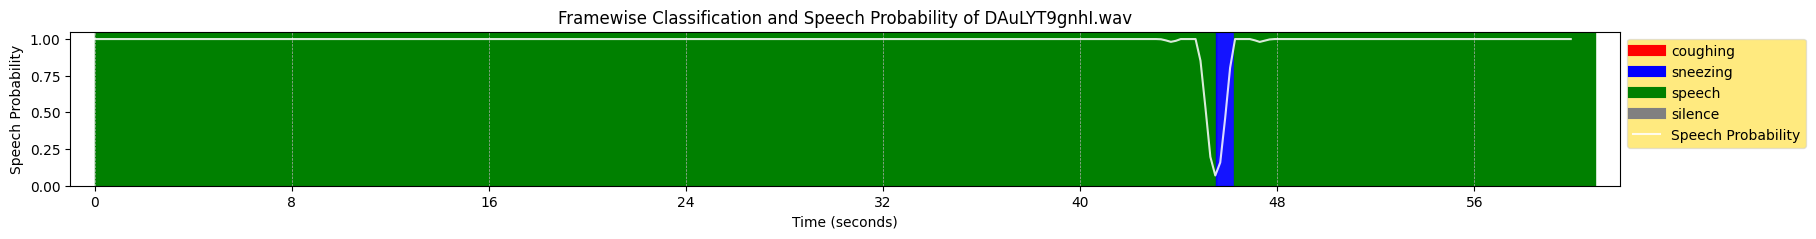

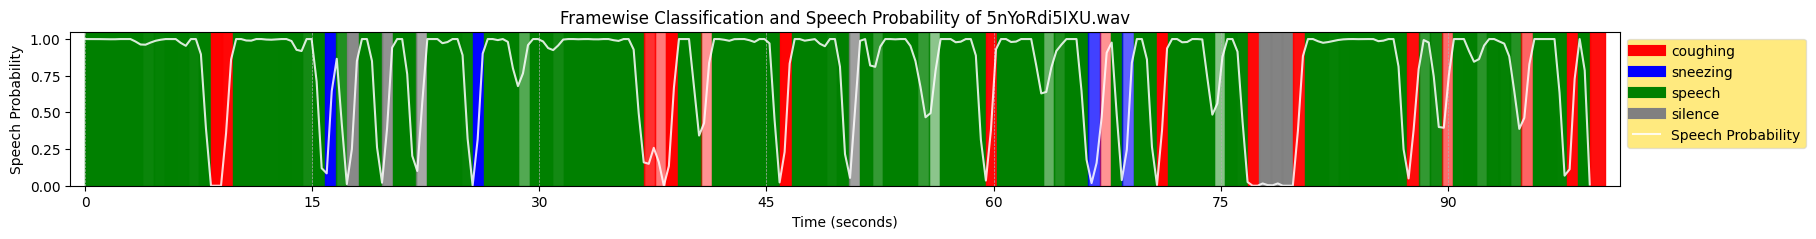

In [ ]:
eg_label = "mixed"
result_path = '/content/drive/MyDrive/PatientVoiceAI/results'
eg_folder = os.path.join(directory, eg_label)
for eg_filename in os.listdir(eg_folder):
    print(eg_filename+": ")
    eg_f = os.path.join(eg_folder, eg_filename)

    # load the audio
    eg_x, eg_sr = librosa.load(eg_f)

    # perform classification
    # eg_y_labels, eg_y_probs = predict_framewise(eg_x)
    frame_duration = 0.75
    eg_y_labels, eg_y_probs, eg_y_speech = predict_shorter_framewise(eg_x,frame_duration)

    # get timestamps
    eg_audio_duration = float(len(eg_x)/eg_sr) # chunk_duration*len(eg_y_labels)
    eg_timestamps = np.linspace(start=0, stop=eg_audio_duration, num=len(eg_y_labels))

    # calculate label ratios as health indicators
    speech_ratio, disruption_ratio = calculate_health_indicators(eg_y_labels)
    # print("speech ratio: ", speech_ratio)
    # print("disruption ratio: ", disruption_ratio)

    # write the classification results and timestamps to a txt file
    with open(os.path.join(result_path,eg_filename[:-4])+".txt", 'w') as fp:
        fp.write(f"speech ratio: {round(speech_ratio, 2)}, disruption ratio: {round(disruption_ratio, 2)}\n")
        for i in range(len(eg_y_labels)):
            fp.write(f"{round(eg_timestamps[i],2)}, {eg_y_labels[i]}, {round(eg_y_probs[i],2)}\n")

    # plot the classification results and timestamps
    plotter = TimescalePlotter(list(eg_timestamps), list(eg_y_labels), list(eg_y_probs), eg_y_speech, eg_filename, eg_label)
    # plotter.plot_speech_probs()
    plotter.plot_allinone()

